# Построение ML-продукта для оптимизации классификации заявок на оплату для сервиса Repetit.ru

**Описание проекта**
<br>Сервис Repetit.ru работает с большим количеством заявок от клиентов с данными о предмете,
<br>желаемой стоимости, возрасте ученика, целью занятий и тд.
<br>К сожалению, 7 из 8 не доходят до оплаты, при этом обработка заявки консультантом увеличивает конверсию в оплату на 30%.
<br>Проблема в том, что консультантов не хватает на все заявки и получается, что чем больше заявок —
<br>тем меньше конверсия из заявки в оплату и консультанты тратят время на бесперспективные заявки.

**Цель:**
- Сократить загрузку отдела консультантов на 30%
- Увеличить конверсию в оплату на 15 п.п. через сегментацию заявок по вероятности их оплаты

**Задачи:**
<br>Разработать модель, которая по имеющейся информации о клиенте и заявке будет предсказывать вероятность оплаты заявки клиентом.
<br>Заказчик хочет понять, какие заявки будут оплачены, а какие нет, чтобы одни обрабатывать вручную консультантами, а другие нет.
<br>Оценка качества модели будет производиться с использованием `precision` и `ROC-AUC`.

**Целевые метрики (пожелания от заказчика)**
- 50-75% от общего объёма заявок можно будет не обрабатывать, так как они не будут оплачены
- обозначение топ 5-25% заявок, которым нужно отдать максимальный приоритет
- допускается, что модель будет показывать больше заявок как хороших, чем на самом деле (ошибка precision оплаченных заявок)
- не допускается, что модель относит потенциально оплаченные заявки к плохим заявкам (низкая precision неоплаченных заявок)

Данные для 0 (неоплачено) и 1 (оплачено) классов.
<br>`recall`, например, для оплаченных заявок показывает процент предсказанных как оплаченные от всех истинно оплаченных заявок. <br>`f1-score` это некий баланс между `precision` и `recall`.
<br>А `support` - кол-во наблюдений отнесенных к тому или иному классу.

|class|precision|recall|f1-score|support|
|--:|--:|--:|--:|--:|
|0|0.89|1.00|0.94|187629|
|1|0.50|0.02|0.04|24097|

**Ход исследования:**
- загрузка данных и ознакомление с ними,
- отбор подходящих признаков,
- EDA,
- создание новых признаков (при необходимости),
- отбор финального набора обучающих признаков,
- выбор и обучение моделей (разных архитектур),
- оценка качества предсказания лучшей модели на тестовой выборке,
- анализ важности признаков лучшей модели,
- создание сервиса в виде Docker Container,
- отчёт по проведённому исследованию.

**Описание данных**
- Заявки (orders*.csv)
  - order_date - дата создания
  - subject_id - предмет
  - purpose - цель занятий
  - lesson_price - цена
  - lesson_duration - желаемая проодолжительность урока
  - home_metro_id - ближайшее метро
  - add_info - доп инфо
  - start_date
  - working_teacher_id
  - status_id - оплачена ли заявка (значения 6 и 13 - факт оплаты заявки, значения 5 и 15 - частичная оплата)
  - comments   
  - amount_to_pay
  - planned_lesson_number - клиент планирует N занятий
  - first_lesson_date - дата 1 занятия
  - coef - коэффициент
  - creator_id - кто создал заявку (id сотрудника или клиента)
  - pupil_category_new_id - возраст ученика
  - lessons_per_week - занятий а неделю
  - minimal_price
  - teacher_sex - пол репетитора
  - teacher_experience_from - опыт репетитора от
  - teacher_experience_to- опыт репетитора до
  - lesson_place_new - онлайн, у ученика, у учителя
  - pupil_knowledgelvl -уровень знаний ученика
  - teacher_age_from - желаемый возраст репеитора от
  - teacher_age_to - желаемый возраст репеитора от
  - chosen_teachers_only - не предлагать репетиторов кроме выбранных самостоятельно
  - no_teachers_available - на заявку нет подходящих репов
  - source_id - где создана заявка (какая часть сайта, не регион)
  - original_order_id - дублем какой заявки является эта заявка
  - client_id - айди клиента
  - additional_status_id
  - max_metro_distance - максимально готов ехать от метро
  - estimated_fee
  - payment_date
  - test_group - аб тесты
  - is_display_to_teachers - хочет ли клиент получать отклики репетиторов

- Репетиторы (teacher_info.csv)
  - date_update
  - reg_date
  - birth_date
  - teaching_start_date
  - user_id - айди
  - is_email_confirmed
  - is_home_lessons
  - is_external_lessons
  - external_comments
  - lesson_duration - продолжит урока
  - lesson_cost - стоимость урока
  - status_id
  - status_relevant_date
  - status_school_id
  - status_college_id
  - status_display
  - russian_level_id
  - home_country_id
  - education
  - information
  - is_confirmed
  - is_display - показывается в каталоге
  - rating_id
  - rating - рейтинг
  - comments
  - rules_confirmed_date
  - last_visited - послеждний визит
  - is_pupils_needed - открыт для заявок
  - is_cell_phone_confirmed
  - effective_rating - какой-то еще рейтинг
  - area_id
  - registrar_id
  - pupil_needed_date
  - sex
  - amount_to_pay - долг
  - is_remote_lessons
  - remote_comments
  - show_on_map
  - send_mailing
  - send_suitable_orders
  - rating_for_users - рейтинг 2
  - rating_for_admin - рейтинг 3
  - passport_id
  - is_edited
  - orders_allowed - разрешено назначать на заявки
  - display_days
  - verification_status_id
  - is_individual
  - partner_id
  - star_rating - рейтинг 4
  - rating_for_users_yesterday - рейтинг вчера
  - review_num - отзывы
  - relevance_date
  - is_display_at_partners
  - video_presentation_id - есть видеопрезентация
  - status_institution_id
  - Free_time_relevance_date


- Подходящие по фильтру репетиторы (suitable_teachers.csv)
  - tteacher_id - id репетитора
  - order_id - id заявки
  - contact_result    
  - enable_auto_assign - доступен ли репетитор к работе или заблокирован
    <br>(может ли репетитора назначить консультант и может ли он сам назначиться)
    <br>(значение известно на момент подачи заявки)
  - enable_assign - доступен ли репетитор к работе или заблокирован
    <br>(может ли репетитора назначить консультант и может ли он сам назначиться)
    <br>(значение известно на момент подачи заявки)


- Желаемые репетиторы (prefered_teachers_order_id.csv)
  <br>Репетиторы, которых выбрал клиент.
  - tteacher_id - id репетитора
  - order_id - id заявки

## Настройка рабочей среды

In [1]:
!pip install shap
!pip install phik
!pip install catboost
!pip install sentence_transformers

In [2]:
import shap
import phik
import torch
import pickle
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, f1_score

warnings.filterwarnings("ignore", category=UserWarning)

Монтирование диска (Google Colab)

In [3]:
from google.colab import userdata
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Подключение к GPU

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Установка констант

In [5]:
RANDOM_STATE = 42
CHUNKSIZE = 10000

Установка `random_state`

In [6]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

## Загрузка данных

In [7]:
try:
  orders = pd.read_feather('data/orders.feather')
  teachers_info = pd.read_feather('data/teachers_info.feather')
  suitable_teachers = pd.read_feather('data/suitable_teachers.feather')
  prefered_teachers_order_id = pd.read_feather('data/prefered_teachers_order_id.feather')
  print('загружено из каталога "data"')
except:
  orders = pd.read_feather(userdata.get('orders_path'))
  teachers_info = pd.read_feather(userdata.get('teachers_info'))
  suitable_teachers = pd.read_feather(userdata.get('suitable_teachers'))
  prefered_teachers_order_id = pd.read_feather(userdata.get('preferred_teachers_order_id'))
  print('загружено из каталога Google Drive')

загружено из каталога Google Drive


### Заявки

In [8]:
orders.info()
orders.sample()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null        

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,...,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
40101,1881671,2021-12-06 17:01:13.553,13.0,Разделы: школьный курс.\nДополнения: ЕГЭ.\nКа...,500,60,None,2276.0,Район: г. Каспийск.\nМесто проведения занятий:...,None,...,0,1,16,NaN,878030,8.0,NaN,None,None,1


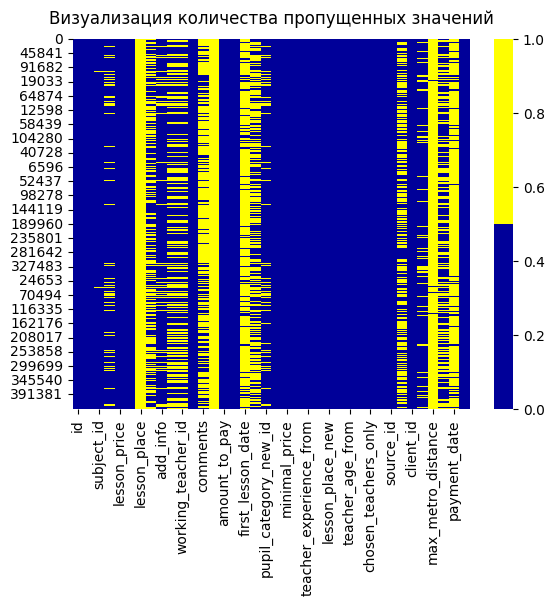

In [9]:
sns.heatmap(orders.isnull(), cmap=sns.color_palette(['#000099', '#ffff00']))
plt.xticks(rotation=90)
plt.title('Визуализация количества пропущенных значений', size=12, y=1.02)
plt.show()

In [10]:
print(f"количество полных дубликатов строк: {orders.duplicated().sum()}")
print(f"""количество полных дубликатов в общем количестве строк:
{orders.duplicated().sum() / orders.shape[0] * 100:.3f}%""")

количество полных дубликатов строк: 900
количество полных дубликатов в общем количестве строк:
0.076%


Удаление обнаруженных повторов строк

In [11]:
orders = orders.drop_duplicates().reset_index(drop=True)

In [12]:
print(f"""уникальные значения status_id:
{orders['status_id'].value_counts().sort_index(ascending=False)}""")

уникальные значения status_id:
3605505         1
3342337         1
3211265         1
16         791756
15           3469
14          32933
13           2111
12           4731
11           7202
9            1057
8            8178
7          212694
6          121413
5             291
4            1852
3            3166
2               3
1             102
Name: status_id, dtype: int64


Удаление строк с некорректным значением status_id

In [13]:
orders = orders.drop(orders[orders['status_id'] > 16].index)

Создание целевого признака

In [14]:
orders['fact_of_payment'] = (orders['status_id']
                             .apply(lambda x: 1 if x == 6 or x == 13
                                    or x == 5 or x == 15 else 0)
                             .astype('int8')
                             )

Изменение типов данных

In [15]:
orders[['order_date', 'start_date', 'first_lesson_date', 'payment_date']] = (
    orders[['order_date', 'start_date', 'first_lesson_date', 'payment_date']]
    .apply(pd.to_datetime)
    )

Создание признака `order_month`

In [16]:
orders['order_month'] = orders['order_date'].dt.month.astype('int8')

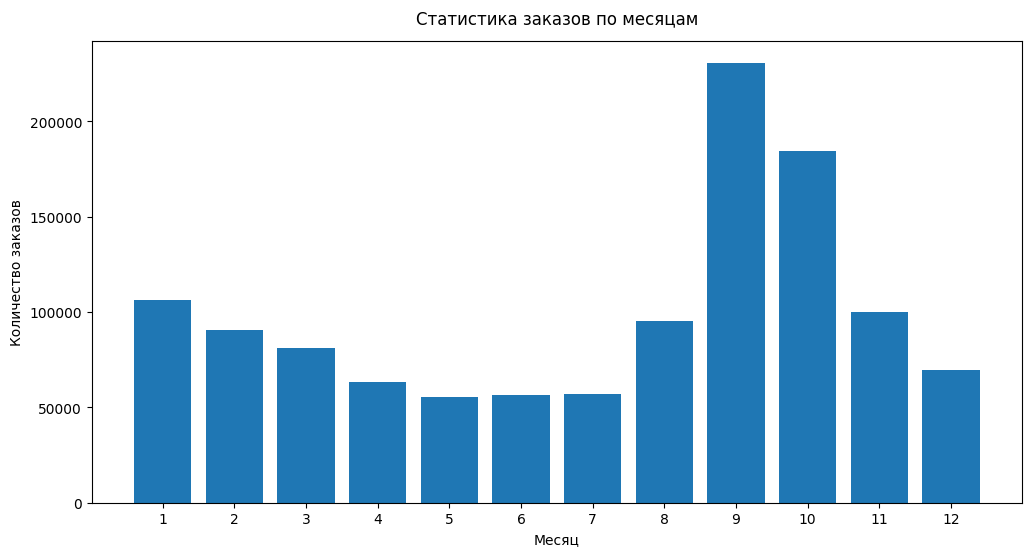

In [17]:
plt.figure(figsize=(12, 6))
plt.bar(orders['order_month'].value_counts().sort_index(ascending=True).index.tolist(),
        orders['order_month'].value_counts().sort_index(ascending=True).tolist())

plt.xlabel('Месяц')
plt.xticks(orders['order_month'].value_counts().sort_index(ascending=True).index.tolist())
plt.ylabel('Количество заказов')
plt.title('Статистика заказов по месяцам', fontsize=12, y=1.02)
plt.show()

In [18]:
print(f"""уникальные значения subject_id:
{orders['subject_id'].value_counts().sort_index(ascending=False)}""")

уникальные значения subject_id:
36.0      5625
33.0     33318
29.0     12622
27.0     12281
25.0      4909
23.0      7281
21.0     24767
20.0     16651
19.0     46684
18.0     64282
17.0      7853
16.0      8171
15.0     11367
14.0     36796
13.0     20048
12.0     42127
11.0     59734
10.0     57223
9.0      58706
8.0     311066
7.0      16147
6.0       8682
5.0       4456
4.0      12595
3.0      17515
2.0     170675
1.0     109052
Name: subject_id, dtype: int64


Удаление строк с некорректным значением subject_id

In [19]:
orders = orders.drop(orders[orders['subject_id'] > 36].index)

Заполнение пропусков в subject_id

In [20]:
'''
пропущенные значения означают, что поле с предметом не заполнено.
на мой взгляд, их логично заполнить нулями.
'''
orders['subject_id'] = orders['subject_id'].fillna(0)

In [21]:
orders['teacher_sex'] = orders['teacher_sex'].astype('int8')
print(f"""уникальные значения teacher_sex:
{orders['teacher_sex'].value_counts().sort_index(ascending=False)}""")

уникальные значения teacher_sex:
3    549412
2    391981
1     46011
0    203554
Name: teacher_sex, dtype: int64


In [22]:
print(f"примеры записей в колонке purpose:\n{orders['purpose'].unique()[:10]}")

примеры записей в колонке purpose:
[None
 'Разделы: начертательная геометрия.\nКатегория ученика: студентка 1 курса.\nЦель занятий: помощь по программе.'
 'Разделы:  школьный курс.\nКатегория ученика: школьник 9 класса.\nЦель занятий: помощь по школьной программе.'
 'Разделы: ораторское искусство.\nКатегория ученика: студент 2 курса.\nЦель занятий: для себя.'
 'Разделы:  школьный курс.\nКатегория ученика: школьник 8 класса.\nЦель занятий:  улучшить успеваемость.'
 'Разделы: теоретическая механика.\nКатегория ученика: студент 2 курса.\nЦель занятий: помощь по предмету.'
 'Разделы:  школьный курс.\nДополнения: ЕГЭ.\nКатегория ученика: школьник 10 класса.\nЦель занятий: подготовить к ЕГЭ, профиль.'
 'Разделы:  школьный курс.\nКатегория ученика: школьник 9 класса.\nЦель занятий: подтянуть по школьной программе, повысить успеваемость.'
 'Разделы: общий курс.\nКатегория ученика: студентка 7 курса, магистратуры.\nУровень знаний: средний (В1).\nЦель занятий: подготовка к поступлению в аспирант

Заполнение пропусков колонки `purpose`

In [23]:
# Заполнение пропущенных значений
orders['purpose'] = orders['purpose'].fillna('data not entered')

In [24]:
print(f"""уникальные значения pupil_knowledgelvl:
{orders['pupil_knowledgelvl'].value_counts().sort_index(ascending=False)}""")

уникальные значения pupil_knowledgelvl:
4      6726
3     46817
2    105377
1     85325
0    946713
Name: pupil_knowledgelvl, dtype: int64


In [25]:
print(f"""количество уникальных значений lesson_price:
{orders['lesson_price'].nunique()}""")

print(f"""количество уникальных значений minimal_price:
{orders['minimal_price'].nunique()}""")

количество уникальных значений lesson_price:
346
количество уникальных значений minimal_price:
168


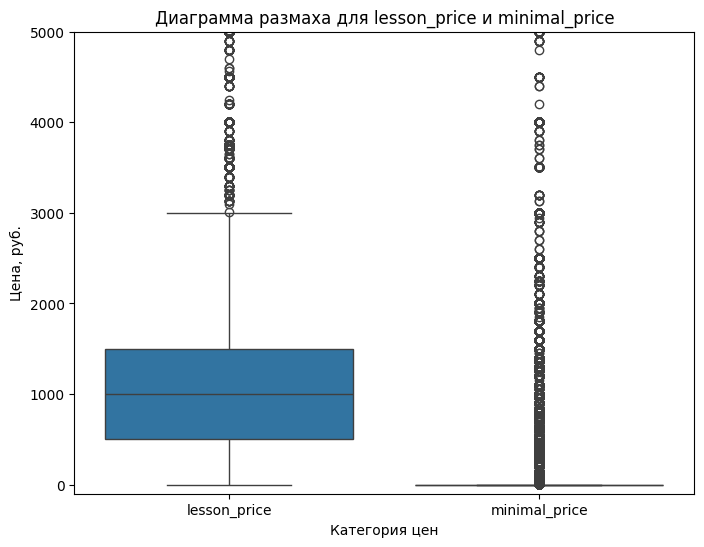

In [26]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=orders[['lesson_price', 'minimal_price']])
plt.ylim(-100, 5000)
plt.title('Диаграмма размаха для lesson_price и minimal_price', size=12)
plt.ylabel('Цена, руб.')
plt.xlabel('Категория цен')
plt.show()

Добавление признака с категорией цены

In [27]:
orders['lesson_price_cat'] = (orders['lesson_price']
                              .apply(lambda x: 1 if x < 500
                                     else 2 if 500 <= x < 1500
                                     else 3 if 1500 <= x <= 3000
                                     else 4)
                              .astype('int8')
                             )

In [28]:
print(f"""уникальные значения lesson_duration:
{orders['lesson_duration'].value_counts().sort_index(ascending=False)}""")

уникальные значения lesson_duration:
135        192
120       7210
90       25634
60     1135634
45       19902
0         2386
Name: lesson_duration, dtype: int64


In [29]:
print(f"""количество уникальных значений home_metro_id:
{orders['home_metro_id'].nunique()}""")

количество уникальных значений home_metro_id:
2323


In [30]:
'''
заполню пропуски в признаке home_metro_id значением '-1'
'''
orders['home_metro_id'] = orders['home_metro_id'].fillna(-1)

In [31]:
print(f"примеры записей в колонке add_info:\n{orders['add_info'].unique()[:10]}")

примеры записей в колонке add_info:
[None
 'Место проведения занятий: дистанционно (например, Skype). Время МСК.\nПредполагаемое число занятий в неделю: 1, будни и суббота после 17, воскресенье в течение дня.'
 'Место проведения занятий: дистанционно (например, Skype).\nПредполагаемое число занятий в неделю: 1-2, вторник, четверг с 17, суббота с 14.\nОпыт репетитора: от 5 лет.\nВозраст репетитора: от 20 лет до 90 лет.\nПол репетитора: не имеет значения.\nСтатус репетитора: школьный преподаватель.'
 'Место проведения занятий: дистанционно (например, Skype) +3 МСК\nПредполагаемое число занятий в неделю: 2-3 (будни после 18 часов +3 МСК).\nОпыт репетитора: не имеет значения.\nВозраст репетитора: не имеет значения.\nПол репетитора: не имеет значения.\nСтатус репетитора: не имеет значения.'
 'Район: м. Перово.\nМесто проведения занятий: у ученика (ул Кусковская ).\nПредполагаемое число занятий в неделю: 1 Воскресенье - в любое время.\nОпыт репетитора: не имеет значения.\nВозраст репетитора:

In [32]:
print(f"""уникальные значения additional_status_id:
{orders['additional_status_id'].value_counts().sort_index(ascending=False)}""")

уникальные значения additional_status_id:
25.0       755
24.0      4235
23.0       169
22.0       387
21.0     25493
20.0      3827
19.0      8026
18.0     14557
17.0    106977
16.0     11184
15.0       691
14.0     16828
13.0    240934
11.0      3344
10.0    177277
9.0       2790
8.0      82225
7.0     261485
6.0       3840
5.0      47774
4.0       3068
3.0      17850
2.0       7066
1.0        805
Name: additional_status_id, dtype: int64


Удаление тестовых заявок

In [33]:
orders = orders.drop(orders[orders['additional_status_id'] == 1].index)

In [34]:
print(f"примеры записей в колонке comments:\n{orders['comments'].unique()[:10]}")

примеры записей в колонке comments:
[None
 '\n01.11.2022 11:46 - "Заявка прикреплена к заявке № 2294000" (Алешина Марина)'
 'Тестовая группа : SplitTestA' 'Тестовая группа : SplitTestB'
 'Тестовая группа : SplitTestB\n01.11.2022 09:07 - "Заявка прикреплена к заявке № 2294059" (Столярова Алена)'
 '\n01.11.2022 09:14 - "Заявка прикреплена к заявке № 2294052" (Дрешпан Екатерина)'
 'Тестовая группа : SplitTestB\n01.11.2022 09:09 - "Заявка прикреплена к заявке № 2293937" (Мищенко Ирина)'
 'Тестовая группа : SplitTestB\n01.11.2022 09:06 - "Заявка прикреплена к заявке № 2293937" (Мищенко Ирина)'
 'Тестовая группа : SplitTestB\n?Статус дозаполнения : начато заполнение клиентом?\n?Статус дозаполнения : Заполнена клиентом?'
 'Тестовая группа : SplitTestA\n01.11.2022 09:25 - "Заявка прикреплена к заявке № 2294084" (Солоненко Анна)']


In [35]:
print(f"""количество уникальных значений amount_to_pay:
{orders['amount_to_pay'].nunique()}""")

количество уникальных значений amount_to_pay:
1412


Изменение типа данных на числовой

In [36]:
orders['amount_to_pay'] = (orders['amount_to_pay']
                           .apply(lambda x: pd.to_numeric(x.replace(',', '.'),
                                                          errors='coerce'))
                           .fillna(0)
                           .astype('float32')
                           )

In [37]:
orders['planned_lesson_number'] = orders['planned_lesson_number'].astype('int8')
print(f"""уникальные значения planned_lesson_number:
{orders['planned_lesson_number'].value_counts().sort_index(ascending=False)}""")

уникальные значения planned_lesson_number:
10    937544
7      68239
2      11619
1       6574
0     166177
Name: planned_lesson_number, dtype: int64


In [38]:
print(f"""уникальные значения pupil_category_new_id:
{orders['pupil_category_new_id'].value_counts().sort_index(ascending=False)}""")

уникальные значения pupil_category_new_id:
17.0      5062
16.0     12319
15.0    113637
14.0     97095
12.0    140795
11.0     90011
10.0    171331
9.0      85261
8.0      71122
7.0      55433
6.0      47274
5.0      38117
4.0      33650
3.0      32635
2.0      18251
1.0      19137
Name: pupil_category_new_id, dtype: int64


Заполнение пропусков в категориях учеников

In [39]:
orders['pupil_category_new_id'] = orders['pupil_category_new_id'].fillna(-1)
orders['pupil_category_new_id'] = orders['pupil_category_new_id'].astype('int8')

уникальные значения lessons_per_week:
7     15060
6     28155
5    156312
4    236217
3    433401
2    142325
1      3864
0    174819
Name: lessons_per_week, dtype: int64


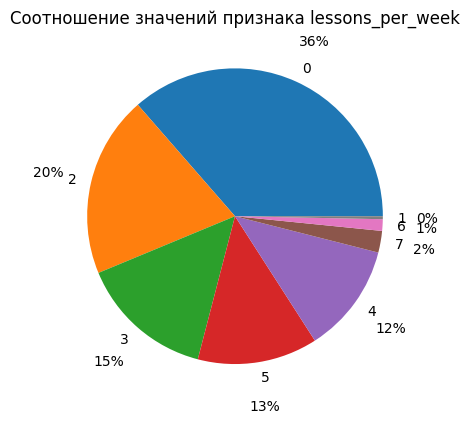

In [40]:
orders['lessons_per_week'] = orders['lessons_per_week'].astype('int8')
print(f"""уникальные значения lessons_per_week:
{orders['lessons_per_week'].value_counts().sort_index(ascending=False)}""")

fig1, ax1 = plt.subplots()
ax1.pie(orders['lessons_per_week'].value_counts(),
        labels=orders['lessons_per_week'].unique(),
        autopct='%1.0f%%',
        pctdistance=1.3)
plt.title('Соотношение значений признака lessons_per_week', size=12)
plt.show()

In [41]:
orders['teacher_experience_from'] = orders['teacher_experience_from'].astype('int8')
print(f"""описание teacher_experience_from:
{orders['teacher_experience_from'].describe()}""")
print(f"""количество уникальных значений teacher_experience_from:
{orders['teacher_experience_from'].nunique()}""")

orders['teacher_experience_to'] = orders['teacher_experience_to'].astype('int8')
print(f"""описание teacher_experience_to:
{orders['teacher_experience_to'].describe()}""")
print(f"""количество уникальных значений teacher_experience_to:
{orders['teacher_experience_to'].nunique()}""")

описание teacher_experience_from:
count    1.190153e+06
mean     1.468199e+00
std      2.784497e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      5.100000e+01
Name: teacher_experience_from, dtype: float64
количество уникальных значений teacher_experience_from:
40
описание teacher_experience_to:
count    1.190153e+06
mean     8.938943e-01
std      8.365584e+00
min     -1.200000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+02
Name: teacher_experience_to, dtype: float64
количество уникальных значений teacher_experience_to:
65


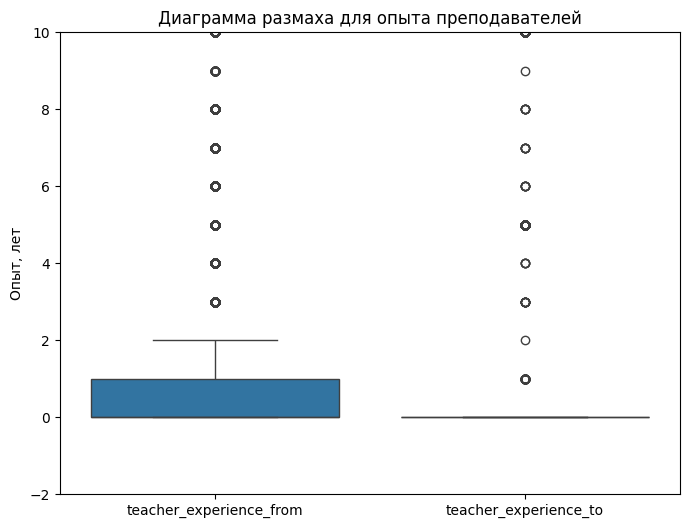

In [42]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=orders[['teacher_experience_from', 'teacher_experience_to']])
plt.ylim(-2, 10)
plt.title('Диаграмма размаха для опыта преподавателей', size=12)
plt.ylabel('Опыт, лет')
plt.show()

In [43]:
orders['teacher_age_from'] = orders['teacher_age_from'].astype('int8')
print(f"""описание teacher_age_from:
{orders['teacher_age_from'].describe()}""")
print(f"""количество уникальных значений teacher_age_from:
{orders['teacher_age_from'].nunique()}""")

orders['teacher_age_to'] = orders['teacher_age_to'].astype('int8')
print(f"""описание teacher_age_to:
{orders['teacher_age_to'].describe()}""")
print(f"""количество уникальных значений teacher_age_to:
{orders['teacher_age_to'].nunique()}""")

описание teacher_age_from:
count    1.190153e+06
mean     8.312320e+00
std      1.194534e+01
min     -1.060000e+02
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+01
max      1.240000e+02
Name: teacher_age_from, dtype: float64
количество уникальных значений teacher_age_from:
83
описание teacher_age_to:
count    1.190153e+06
mean     1.726183e+01
std      2.795748e+01
min     -1.280000e+02
25%      0.000000e+00
50%      0.000000e+00
75%      4.000000e+01
max      1.120000e+02
Name: teacher_age_to, dtype: float64
количество уникальных значений teacher_age_to:
104


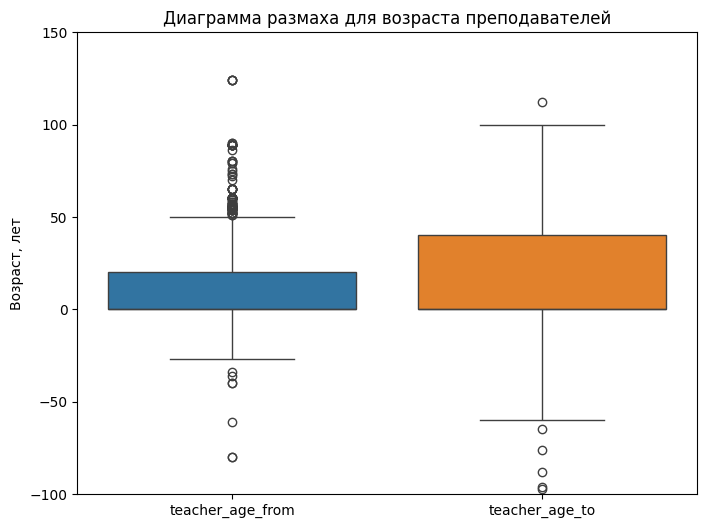

In [44]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=orders[['teacher_age_from', 'teacher_age_to']])
plt.ylim(-100, 150)
plt.title('Диаграмма размаха для возраста преподавателей', size=12)
plt.ylabel('Возраст, лет')
plt.show()

уникальные значения chosen_teachers_only:
1      26632
0    1163521
Name: chosen_teachers_only, dtype: int64


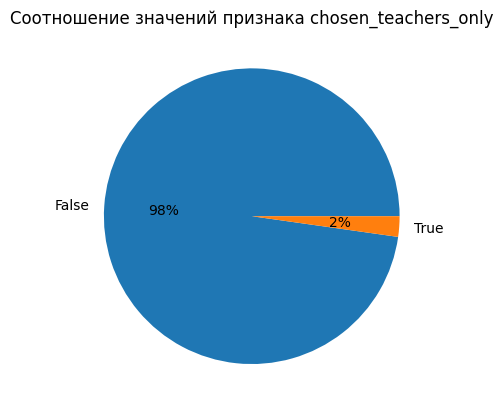

In [45]:
print(f"""уникальные значения chosen_teachers_only:
{orders['chosen_teachers_only'].value_counts().sort_index(ascending=False)}""")

labels = 'False', 'True'
sizes = [orders['chosen_teachers_only'].value_counts()[0],
         orders['chosen_teachers_only'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.0f%%')
plt.title('Соотношение значений признака chosen_teachers_only', size=12)
plt.show()

уникальные значения no_teachers_available:
1     108204
0    1081949
Name: no_teachers_available, dtype: int64


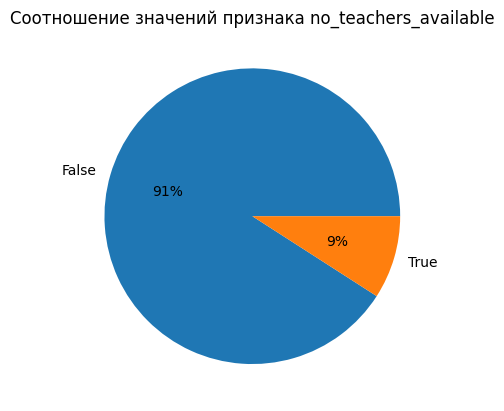

In [46]:
print(f"""уникальные значения no_teachers_available:
{orders['no_teachers_available'].value_counts().sort_index(ascending=False)}""")

labels = 'False', 'True'
sizes = [orders['no_teachers_available'].value_counts()[0],
         orders['no_teachers_available'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.0f%%')
plt.title('Соотношение значений признака no_teachers_available', size=12)
plt.show()

In [47]:
orders['source_id'] = orders['source_id'].astype('int8')
print(f"""уникальные значения source_id:
{orders['source_id'].value_counts().sort_index(ascending=False)}""")

уникальные значения source_id:
26        38
25      2428
24     15862
23    441495
22      7780
20        10
18     10010
17      8881
16    279828
14    334210
13      1251
12       277
11        17
9      14611
8      49492
7        736
6       1037
5       3764
4       9826
3        182
2       7907
0        511
Name: source_id, dtype: int64


In [48]:
print(f"""количество уникальных значений original_order_id:
{orders['original_order_id'].nunique()}""")

количество уникальных значений original_order_id:
314852


In [49]:
# Создание групп по original_order_id
orders['order_group'] = orders['original_order_id'].fillna(orders['id'])

# Проверка и заполнение поля fact_of_payment для групп
orders['fact_of_payment'] = (orders
                             .groupby('order_group')['fact_of_payment']
                             .transform(lambda x: 1 if x.any() else x))

# Удаление дубликатов заявок
orders = orders[orders['original_order_id'].isnull()]

# Удаление временного столбца group
orders = orders.drop('order_group', axis=1)

In [50]:
print(f"текущая размерность таблицы: {orders.shape}")
print(f"текущее количество уникальных номеров заявок: {orders['id'].nunique()}")

текущая размерность таблицы: (608083, 41)
текущее количество уникальных номеров заявок: 608083


Создание копии датафрейма без лишних признаков

In [51]:
orders_processed = orders.copy()
orders_processed = orders_processed.drop(['order_date',
                                          # 'purpose',
                                          'lesson_price',
                                          'lesson_place',
                                          'add_info',
                                          'start_date',
                                          # 'working_teacher_id',
                                          'status_id',
                                          'comments',
                                          'prefered_teacher_id',
                                          'first_lesson_date',
                                          'creator_id',
                                          'teacher_age_from',
                                          'teacher_age_to',
                                          'original_order_id',
                                          'client_id',
                                          'additional_status_id',
                                          'max_metro_distance',
                                          'estimated_fee',
                                          'payment_date',
                                          'is_display_to_teachers'],
                                         axis=1)

In [52]:
orders_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 608083 entries, 2 to 1190958
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       608083 non-null  int32  
 1   subject_id               608083 non-null  float32
 2   purpose                  608083 non-null  object 
 3   lesson_duration          608083 non-null  int32  
 4   home_metro_id            608083 non-null  float32
 5   working_teacher_id       406283 non-null  float32
 6   amount_to_pay            608083 non-null  float32
 7   planned_lesson_number    608083 non-null  int8   
 8   pupil_category_new_id    608083 non-null  int8   
 9   lessons_per_week         608083 non-null  int8   
 10  minimal_price            608083 non-null  int32  
 11  teacher_sex              608083 non-null  int8   
 12  teacher_experience_from  608083 non-null  int8   
 13  teacher_experience_to    608083 non-null  int8   
 14  les

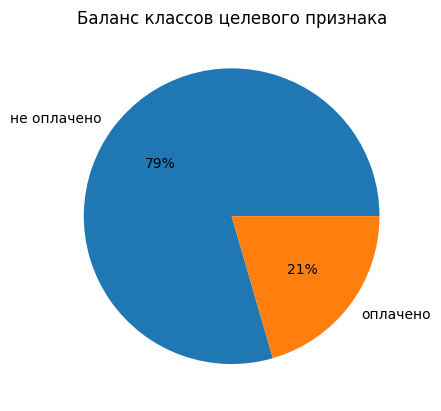

In [53]:
labels = 'не оплачено', 'оплачено'
sizes = [orders_processed['fact_of_payment'].value_counts()[0],
         orders_processed['fact_of_payment'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.0f%%')
plt.title('Баланс классов целевого признака', size=12)
plt.show()

Анализ корреляционных связей между отобранными признаками

interval columns not set, guessing: ['subject_id', 'lesson_duration', 'home_metro_id', 'amount_to_pay', 'planned_lesson_number', 'pupil_category_new_id', 'lessons_per_week', 'minimal_price', 'teacher_sex', 'teacher_experience_from', 'teacher_experience_to', 'lesson_place_new', 'pupil_knowledgelvl', 'chosen_teachers_only', 'no_teachers_available', 'source_id', 'fact_of_payment', 'order_month', 'lesson_price_cat']


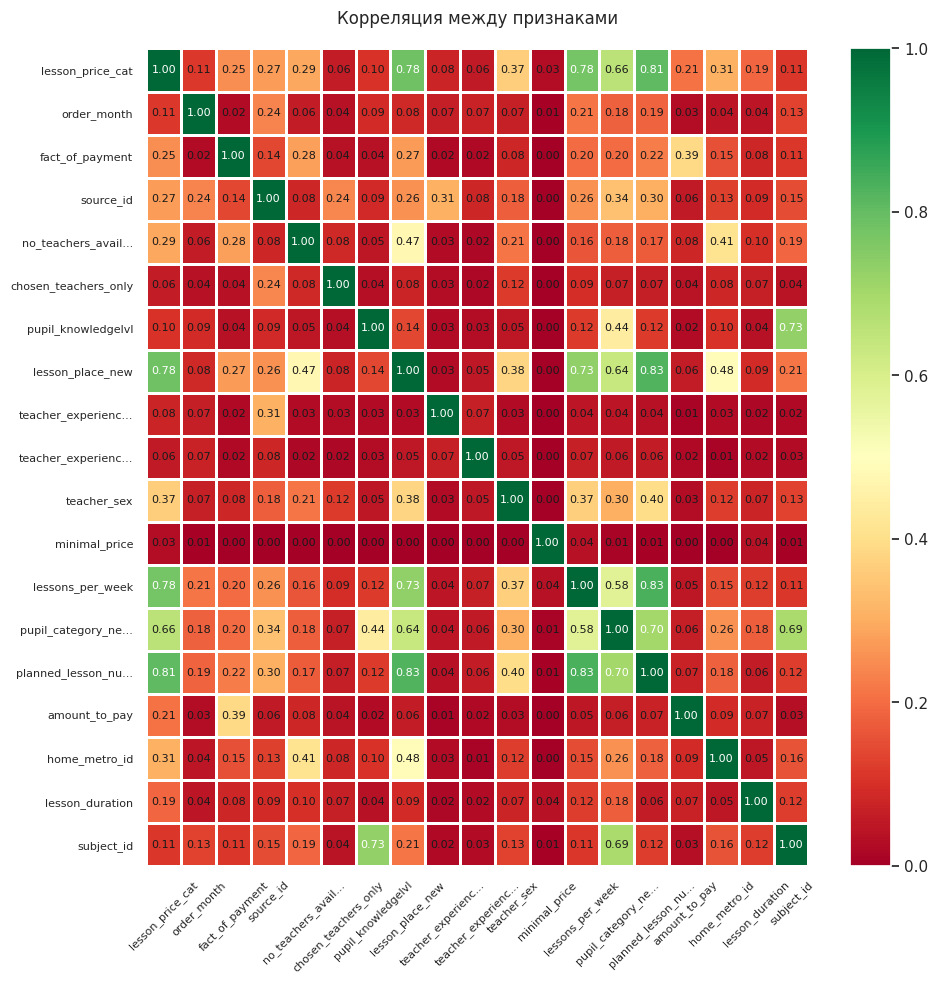

In [54]:
phik_overview = orders_processed.drop(columns=['id',
                                               'working_teacher_id',
                                               'purpose']).phik_matrix()

sns.set()
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1,
                        fontsize_factor=0.8, figsize=(10, 10))
plt.xticks(rotation=45)
plt.title('Корреляция между признаками', fontsize=12, y=1.02)
plt.tight_layout()

In [55]:
print(f"остаток данных от начального размера: {orders_processed.shape[0] / 1191861 * 100:.0f}%")

остаток данных от начального размера: 51%


#### Выводы и наблюдения
- в таблице обнаружены дубликаты строк (0.076% от общего количества данных);
- принято решение об удалении найденных повторов ввиду их малочисленности;
- удалены три строки с некорректными значениями признака `status_id`;
- создан целевой признак `fact_of_payment`;
- даты преобразованы в корректный формат;
- из даты `order_date` создан признак `order_month`;
- наиболее загруженный заказами месяц - сентябрь, наименее загруженные - май, июнь и июль;
- удалены четыре строки с некорректными значениями признака `subject_id`;
- пропуски в признаке `subject_id` (10325 штук) заполнены нулями;
- в признаке `teacher_sex` четыре уникальных значения. По данным от Заказчика: 1 - М, 2 - Ж;
- в колонке `purpose` заполнены пропущенные значения. При необходимости её можно будет разделить на дополнительные признаки: `pupil_section`, `pupil_additions`, `pupil_category`, `pupil_knlvl`, `pupil_goal`. Либо - закодировать, как единый признак через text features. Либо получить эмбеддинги и работать с ними;
- в признаках `lesson_price` и `minimal_price` большое количество выбросов, возможно, данные вносились не совсем корректно;
- введён новый признак с категориями стоимости уроков `lesson_price_cat`;
- желаемая продолжительность занятия варьируется от 0 до 135-ти минут (категориальный признак);
- в признаке `lesson_place` всего 31 запись - принимаю решение об его удалении;
- признаки, неизвестные на момент формирования заявки, удалены (`start_date`, `first_lesson_date`, `payment_date`)
- пропуски в признаке `home_metro_id` заполнены значением `-1`
- `add_info` и `comments` данные записаны в неудобном формате. Принимаю решение их исключить;
- изменён тип данных в признаке `amount_to_pay`;
- по данным из признаков об опыте работы преподавателей трудно сказать, насколько они правдоподобны. Принимаю решение пока их оставить. В дальнейшем, возможно, признаки будут исключены;
- в данных о возрасте преподавателей имеются отрицательные значения - они могли быть внесены случайно (минус использовался в качестве дефиса). Также в этих данных много выбросов. Принимаю решение об удалении признаков возраста;
- удалены все дубликатные заявки, статум оплаты проставлен в исходные;
- удалены заявки (803 штуки) со статусом '1' в `additional_status_id`, т.к. эти заявки являются тестовыми по информации от Заказчика;
- создана копия датафрейма без признаков, не представляющих ценности для исследования;
- наблюдается значительный дисбаланс классов целевого признака;
- анализ матрицы корреляций показывает:
  - линейных связей с целевым признаком у других признаков не наблюдается;
  - есть прямые зависимости между признаками lesson_price_cat, planned_lesson_number, lessons_per_week, lesson_place_new
- после обработки осталось 51% данных от начального объёма.

### Репетиторы

In [56]:
teachers_info.info()
teachers_info.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          307972 non-null  int32   
 1   date_update                 307972 non-null  category
 2   reg_date                    307972 non-null  category
 3   birth_date                  307972 non-null  category
 4   teaching_start_date         307972 non-null  category
 5   user_id                     307972 non-null  int32   
 6   is_email_confirmed          307972 non-null  int8    
 7   is_home_lessons             307972 non-null  int8    
 8   is_external_lessons         307972 non-null  int8    
 9   external_comments           90978 non-null   category
 10  lesson_duration             307972 non-null  int16   
 11  lesson_cost                 307972 non-null  int32   
 12  status_id                   307972 non-null  int8    
 13 

,id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,...,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
121406,124796,2023-01-19 19:11:20.170,2017-08-17 11:06:05.000,1996-06-06 00:00:00.000,2014-09-01 00:00:00.000,263202,0,0,1,Ближайший район: Орджоникидзевский район.,...,0,0.0,ya_reg_own_sn_repetitor-ru-on-center,4.300781,0.0,0,2017-08-17 11:06:05.000,1,NaN,NaN
233813,238275,2023-01-19 18:04:11.497,2021-08-17 11:58:09.837,1999-08-20 00:00:00.000,2017-11-01 00:00:00.000,829149,0,0,0,NaN,...,0,NaN,NaN,4.300781,0.0,0,2021-08-17 11:58:09.837,1,NaN,NaN
258038,262652,2023-01-19 18:19:58.573,2022-06-12 14:30:49.817,1958-10-15 00:00:00.000,1983-08-01 00:00:00.000,973218,0,0,0,NaN,...,0,NaN,NaN,4.300781,0.0,0,2022-06-12 14:30:49.817,1,NaN,NaN


In [57]:
print(f"количество полных дубликатов строк: {teachers_info.duplicated().sum()}")

количество полных дубликатов строк: 0


#### Выводы и наблюдения
- в таблице полных дубликатов строк не обнаружено
- данные из таблицы teachers_info не примут участия в обучении моделей, т.к. на момент формирования заявки эти данные могут быть не доступны.

### Подходящие по фильтру репетиторы

In [58]:
suitable_teachers.info()
suitable_teachers.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271186 entries, 0 to 20271185
Data columns (total 5 columns):
 #   Column              Dtype   
---  ------              -----   
 0   teacher_id          int32   
 1   order_id            int32   
 2   contact_result      category
 3   enable_auto_assign  int8    
 4   enable_assign       int8    
dtypes: category(1), int32(2), int8(2)
memory usage: 232.3 MB


,teacher_id,order_id,contact_result,enable_auto_assign,enable_assign
7951303,197612,2494147,NaN,0,0
3879323,199354,2137750,о,0,0
2205245,222853,1971779,.,0,0


In [59]:
print(f"количество полных дубликатов строк: {suitable_teachers.duplicated().sum()}")
print(f"""количество полных дубликатов в общем количестве строк:
{suitable_teachers.duplicated().sum() / suitable_teachers.shape[0] * 100:.4f}%""")

количество полных дубликатов строк: 49
количество полных дубликатов в общем количестве строк:
0.0002%


Удаление обнаруженных повторов

In [60]:
suitable_teachers = suitable_teachers.drop_duplicates().reset_index(drop=True)

In [61]:
print(f"""уникальные записи колонки contact_result:
{suitable_teachers['contact_result'].unique()}""")
print(f"""количество уникальных записей колонки contact_result:
{suitable_teachers['contact_result'].nunique()}""")

уникальные записи колонки contact_result:
['Репетитор согласился', 'Репетитор положил трубку, либо обрыв связи (O..., ',', NaN, 'Не дозвонились (Oktell)', ..., 'Богородский', '23 екат', 'Репетитор согласился с дополнительными услови..., 'Репетитор согласился с дополнительными услови..., 'к ученику?']
Length: 10867
Categories (10866, object): ['\nРепетитор оставил запрос : ', '\nРепетитор оставил запрос : \nРепетитор оста...,
                             '\nРепетитор оставил запрос : Договорились о з..., '\nРепетитор оставил запрос : О занятии догово...,
                             ..., '№',
                             '№1 анкета понравилась, кл пока не хочет конта..., '№2 анкета не понравилась',
                             '№3 анкета отправлена,  кл еще не смотрела']
количество уникальных записей колонки contact_result:
10866


In [62]:
print(f"""уникальные значения enable_auto_assign:
{suitable_teachers['enable_auto_assign']
 .value_counts().sort_index(ascending=False)}""")

print(f"""уникальные значения enable_assign:
{suitable_teachers['enable_assign']
 .value_counts().sort_index(ascending=False)}""")

уникальные значения enable_auto_assign:
1     2617173
0    17653964
Name: enable_auto_assign, dtype: int64
уникальные значения enable_assign:
1      558434
0    19712703
Name: enable_assign, dtype: int64


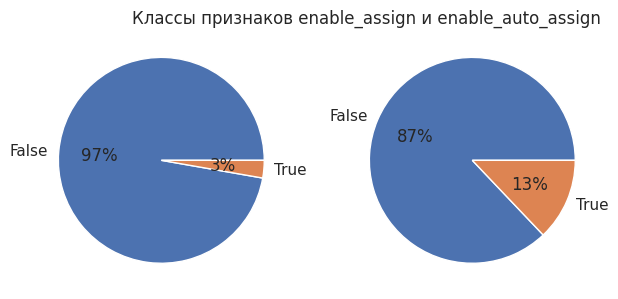

In [63]:
labels = [False, True]
sizes_ea = [suitable_teachers['enable_assign'].value_counts()[0],
            suitable_teachers['enable_assign'].value_counts()[1]]
fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.pie(sizes_ea, labels=labels, autopct='%1.0f%%')

sizes_eaa = [suitable_teachers['enable_auto_assign'].value_counts()[0],
             suitable_teachers['enable_auto_assign'].value_counts()[1]]
ax2.pie(sizes_eaa, labels=labels, autopct='%1.0f%%')

plt.title('Классы признаков enable_assign и enable_auto_assign', size=12, loc='right')
plt.tight_layout()
plt.show()

#### Выводы и наблюдения
- в таблице обнаружены дубликаты строк (0.0002% от общего количества данных)
- принято решение об удалении найденных повторов ввиду их малочисленности
- к категориальным признакам относятся: enable_auto_assign и enable_assign
- в признаке contact_result внесена информация в произвольном формате,
  <br>имеются совсем неинформативные записи ('23 екат', '...')

### Желаемые репетиторы (которых выбрал клиент)

In [64]:
prefered_teachers_order_id.info()
prefered_teachers_order_id.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1135198 entries, 0 to 1135197
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype
---  ------      --------------    -----
 0   order_id    1135198 non-null  int32
 1   teacher_id  1135198 non-null  int32
dtypes: int32(2)
memory usage: 8.7 MB


,order_id,teacher_id
198577,1760293,38193
219191,2191747,81008
1089470,2388892,203361


In [65]:
print(f"""количество полных дубликатов строк:
{prefered_teachers_order_id.duplicated().sum()}""")
print(f"""количество полных дубликатов в общем количестве строк:
{prefered_teachers_order_id.duplicated().sum() /
 prefered_teachers_order_id.shape[0] * 100:.3f}%""")

количество полных дубликатов строк:
16
количество полных дубликатов в общем количестве строк:
0.001%


Удаление обнаруженных повторов

In [66]:
prefered_teachers_order_id = (prefered_teachers_order_id
                              .drop_duplicates()
                              .reset_index(drop=True)
                              )

#### Выводы и наблюдения
- в таблице обнаружены дубликаты строк (0.001% от общего количества данных)
- принято решение об удалении найденных повторов ввиду их малочисленности

## Подготовка данных

### Объединение таблиц

In [67]:
df = (orders_processed
      .merge(suitable_teachers[['teacher_id', 'order_id']],
             how='left',
             left_on=['id', 'working_teacher_id'],
             right_on=['order_id', 'teacher_id'])
      .drop_duplicates()
      .reset_index(drop=True)
      .merge(prefered_teachers_order_id,
             how='left',
             left_on=['id', 'working_teacher_id'],
             right_on=['order_id', 'teacher_id'])
      .drop_duplicates()
      .reset_index(drop=True)
      )

Создание признака `right_teacher`

In [68]:
df['right_teacher'] = (np.where((df['working_teacher_id'] == df['teacher_id_x']) &
 (df['working_teacher_id'] == df['teacher_id_y']), 1, 0)
.astype('int8')
)

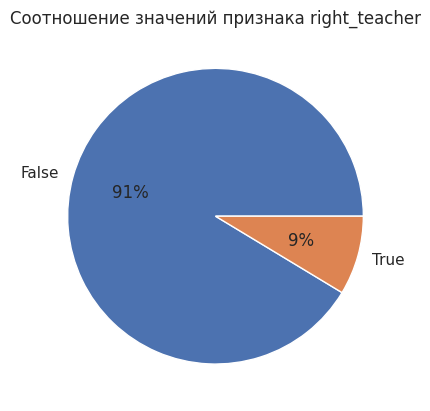

In [69]:
labels = 'False', 'True'
sizes = [df['right_teacher'].value_counts()[0],
         df['right_teacher'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.0f%%')
plt.title('Соотношение значений признака right_teacher', size=12)
plt.show()

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608083 entries, 0 to 608082
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       608083 non-null  int32  
 1   subject_id               608083 non-null  float32
 2   purpose                  608083 non-null  object 
 3   lesson_duration          608083 non-null  int32  
 4   home_metro_id            608083 non-null  float32
 5   working_teacher_id       406283 non-null  float32
 6   amount_to_pay            608083 non-null  float32
 7   planned_lesson_number    608083 non-null  int8   
 8   pupil_category_new_id    608083 non-null  int8   
 9   lessons_per_week         608083 non-null  int8   
 10  minimal_price            608083 non-null  int32  
 11  teacher_sex              608083 non-null  int8   
 12  teacher_experience_from  608083 non-null  int8   
 13  teacher_experience_to    608083 non-null  int8   
 14  less

Удаление временных признаков

In [71]:
df = df.drop(['working_teacher_id',
             'teacher_id_x',
             'order_id_x',
             'order_id_y',
             'teacher_id_y'], axis=1)

Анализ корреляционных связей в конечных данных

interval columns not set, guessing: ['subject_id', 'lesson_duration', 'home_metro_id', 'amount_to_pay', 'planned_lesson_number', 'pupil_category_new_id', 'lessons_per_week', 'minimal_price', 'teacher_sex', 'teacher_experience_from', 'teacher_experience_to', 'lesson_place_new', 'pupil_knowledgelvl', 'chosen_teachers_only', 'no_teachers_available', 'source_id', 'fact_of_payment', 'order_month', 'lesson_price_cat', 'right_teacher']


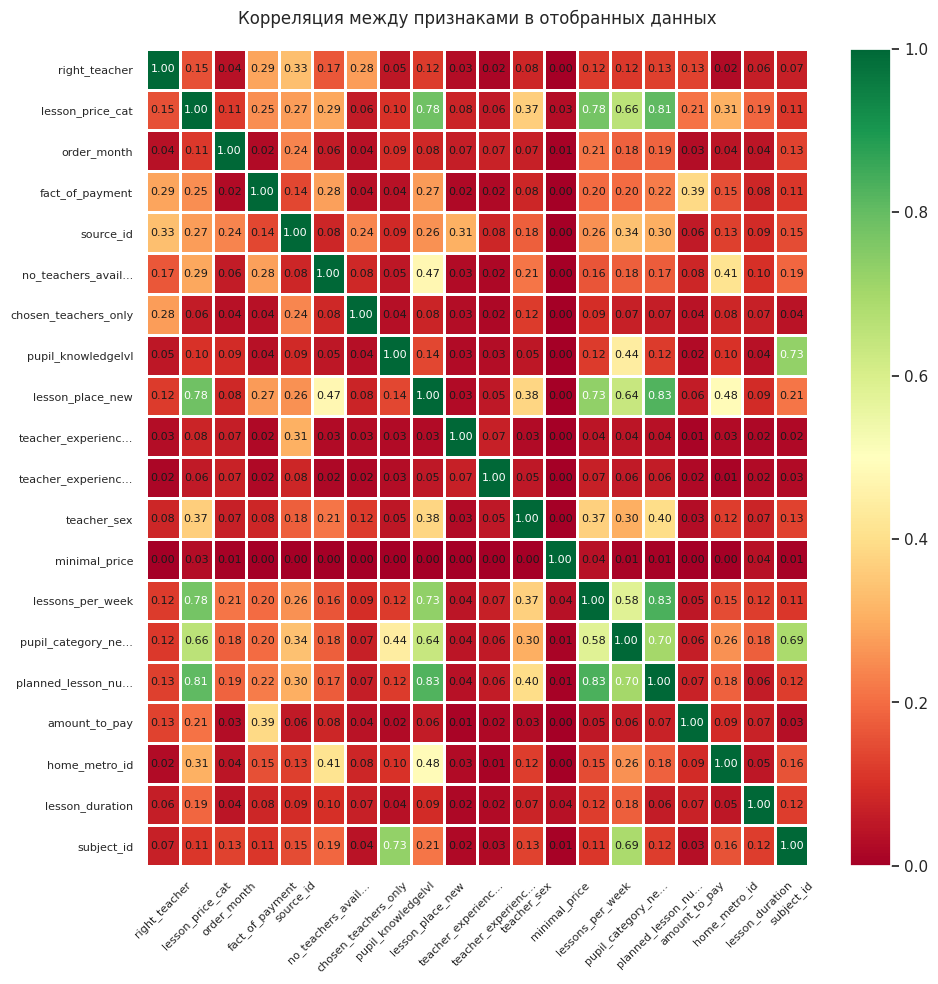

In [72]:
phik_overview_fin = df.drop(columns=['id', 'purpose']).phik_matrix()

sns.set()
plot_correlation_matrix(phik_overview_fin.values,
                        x_labels=phik_overview_fin.columns,
                        y_labels=phik_overview_fin.index,
                        vmin=0, vmax=1,
                        fontsize_factor=0.8, figsize=(10, 10))
plt.xticks(rotation=45)
plt.title('Корреляция между признаками в отобранных данных', fontsize=12, y=1.02)
plt.tight_layout()

#### Выводы и наблюдения
- к таблице `orders` добавлены две другие таблицы по общоим колонкам: `order_id` и `teacher_id`
- добавлен категориальный признак `right_teacher`
- из окончательной таблицы удалены лишние признаки
- анализ матрицы корреляций окончательных признаков указывает:
  - линейных связей с целевым признаком у других признаков не наблюдается;
  - есть прямые зависимости между признаками lesson_price_cat, planned_lesson_number, lessons_per_week, lesson_place_new

### Масштабирование и кодирование данных

Кодирование текстов при помощи Sentence Transformer

In [74]:
minilm = SentenceTransformer('all-MiniLM-L6-v2', device=device)

In [ ]:
# embeddings = minilm.encode(df['purpose'].values, device=device)
# embeddings.shape

(608083, 384)

Сохранение эмбеддингов в файл

In [ ]:
# with open('embeddings.pkl', 'wb') as f:
#     pickle.dump(embeddings, f)

Загрузка эмбеддингов из файла

In [75]:
try:
  with open('data//embeddings.pkl', 'rb') as f:
    loaded_embeddings = pickle.load(f)
except:
  with open(userdata.get('embeddings'), 'rb') as f:
    loaded_embeddings = pickle.load(f)
loaded_embeddings.shape

(608083, 384)

Соединение эмбеддингов с остальными признаками

In [80]:
try:
  compressed_embeddings = np.mean(embeddings, axis=1)
except:
  compressed_embeddings = np.mean(loaded_embeddings, axis=1)
compressed_embeddings.shape

(608083,)

In [83]:
df['purpose_emb'] = compressed_embeddings
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608083 entries, 0 to 608082
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       608083 non-null  int32  
 1   subject_id               608083 non-null  float32
 2   purpose                  608083 non-null  object 
 3   lesson_duration          608083 non-null  int32  
 4   home_metro_id            608083 non-null  float32
 5   amount_to_pay            608083 non-null  float32
 6   planned_lesson_number    608083 non-null  int8   
 7   pupil_category_new_id    608083 non-null  int8   
 8   lessons_per_week         608083 non-null  int8   
 9   minimal_price            608083 non-null  int32  
 10  teacher_sex              608083 non-null  int8   
 11  teacher_experience_from  608083 non-null  int8   
 12  teacher_experience_to    608083 non-null  int8   
 13  lesson_place_new         608083 non-null  int32  
 14  pupi

Разбиение на числовые признаки, целевой признак и id

In [91]:
order_id = df['id']
y = df['fact_of_payment']
X = df.drop(['id', 'fact_of_payment'], axis=1)
X.shape, y.shape

((608083, 21), (608083,))

Приведение данных к единому масштабу

In [92]:
scaler = StandardScaler()
X_es = (pd.DataFrame(scaler.fit_transform(X.drop(['purpose'], axis=1)),
                     columns=X.drop(['purpose'], axis=1).columns,
                     index=X.drop(['purpose'], axis=1).index)
.merge(X['purpose'],
       how='left',
       left_index=True,
       right_index=True,
       sort=False)
)

Разделение данных на выборки

In [93]:
X_train, X_test, y_train, y_test = (train_test_split(X_es,
                                                     y,
                                                     test_size=0.1,
                                                     random_state=RANDOM_STATE,
                                                     stratify=y)
)
X_train, X_valid, y_train, y_valid = (train_test_split(X_train,
                                                       y_train,
                                                       test_size=0.2,
                                                       random_state=RANDOM_STATE,
                                                       stratify=y_train)
)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((437819, 21), (109455, 21), (60809, 21), (437819,), (109455,), (60809,))

#### Выводы и наблюдения
- из данных вынесены целевой и текстовый признаки;
- произведено масштабирование числовых данных и кодирование текстовых;
- произведено разделение на обучающую, валидационную и тестовую выборки.

## Обучение моделей

### Baseline (Logistic Regression)

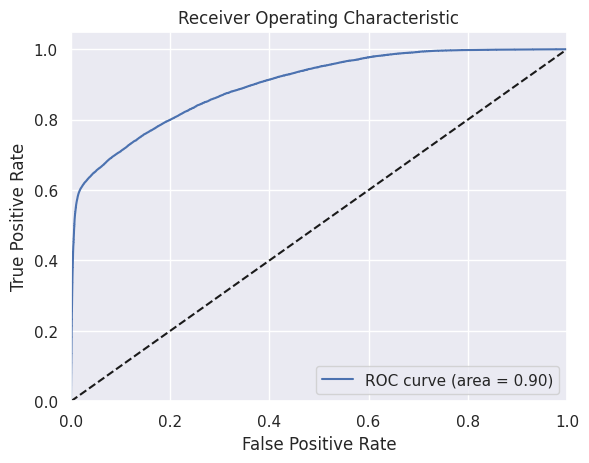

ROC-AUC на валидационной выборке: 0.9
Precision на валидационной выборке: 0.92
F1 на валидационной выборке: 0.71


In [94]:
baseline = LogisticRegression(random_state=RANDOM_STATE)
baseline.fit(X_train.drop(['purpose'], axis=1).values, y_train)

# Вычисление ROC-AUC
y_pred_base = baseline.predict_proba(X_valid.drop(['purpose'], axis=1).values)[:, 1]
roc_auc_baseline = roc_auc_score(y_valid, y_pred_base)

# Вычисление precision и F1
y_pred_class_base = baseline.predict(X_valid.drop(['purpose'], axis=1).values)
precision_baseline = precision_score(y_valid, y_pred_class_base)
f1_baseline = f1_score(y_valid, y_pred_class_base)

# Визуализация кривой ROC
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_valid, y_pred_base)
plt.plot(fpr_lg, tpr_lg, label='ROC curve (area = %0.2f)' % roc_auc_baseline)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"ROC-AUC на валидационной выборке: {round(roc_auc_baseline, 2)}")
print(f"Precision на валидационной выборке: {round(precision_baseline, 2)}")
print(f"F1 на валидационной выборке: {round(f1_baseline, 2)}")

### CatBoost

Learning rate set to 0.142334
0:	test: 0.8517459	best: 0.8517459 (0)	total: 904ms	remaining: 15m 2s
100:	test: 0.9197692	best: 0.9197692 (100)	total: 1m 37s	remaining: 14m 29s
200:	test: 0.9211429	best: 0.9211429 (200)	total: 3m 7s	remaining: 12m 23s
300:	test: 0.9216760	best: 0.9216760 (300)	total: 4m 29s	remaining: 10m 26s
400:	test: 0.9219264	best: 0.9219264 (400)	total: 5m 53s	remaining: 8m 47s
500:	test: 0.9221089	best: 0.9221092 (498)	total: 7m 14s	remaining: 7m 12s
600:	test: 0.9223236	best: 0.9223236 (600)	total: 8m 36s	remaining: 5m 42s
700:	test: 0.9224528	best: 0.9224528 (700)	total: 10m 1s	remaining: 4m 16s
800:	test: 0.9224590	best: 0.9224741 (782)	total: 11m 22s	remaining: 2m 49s
900:	test: 0.9225264	best: 0.9225264 (900)	total: 12m 41s	remaining: 1m 23s
999:	test: 0.9225931	best: 0.9225940 (974)	total: 14m	remaining: 0us

bestTest = 0.9225939847
bestIteration = 974

Shrink model to first 975 iterations.


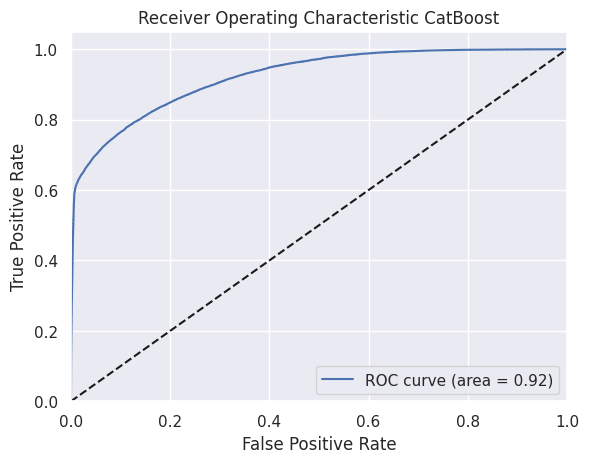

ROC-AUC на валидационной выборке: 0.92
Precision на валидационной выборке: 0.93
F1 на валидационной выборке: 0.74


In [95]:
cbst = CatBoostClassifier(random_state=RANDOM_STATE,
                          text_features=['purpose'],
                          eval_metric='AUC')
cbst.fit(X_train.drop(['purpose_emb'], axis=1),
         y_train,
         eval_set=(X_valid.drop(['purpose_emb'], axis=1), y_valid),
         verbose=100)

# Вычисление ROC-AUC
y_pred_proba_cb = cbst.predict_proba(X_valid.drop(['purpose_emb'], axis=1))[:, 1]
roc_auc_cb = roc_auc_score(y_valid, y_pred_proba_cb)

# Вычисление precision и F1
y_pred_class_cb = cbst.predict(X_valid.drop(['purpose_emb'], axis=1).values)
precision_cb = precision_score(y_valid, y_pred_class_cb)
f1_cb = f1_score(y_valid, y_pred_class_cb)

# Визуализация кривой ROC
fpr_cb, tpr_cb, thresholds_cb = roc_curve(y_valid, y_pred_proba_cb)
plt.plot(fpr_cb, tpr_cb, label='ROC curve (area = %0.2f)' % roc_auc_cb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic CatBoost')
plt.legend(loc="lower right")
plt.show()

print(f"ROC-AUC на валидационной выборке: {round(roc_auc_cb, 2)}")
print(f"Precision на валидационной выборке: {round(precision_cb, 2)}")
print(f"F1 на валидационной выборке: {round(f1_cb, 2)}")

### LightGBM

[LightGBM] [Warning] Unknown parameter: valid_sets
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x79dd34051fc0>
[LightGBM] [Warning] Unknown parameter: plot
[LightGBM] [Warning] Unknown parameter: valid_sets
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x79dd3402ccd0>
[LightGBM] [Warning] Unknown parameter: plot
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 437819, number of used features: 20
[LightGBM] [Info] Start training from score 0.205094


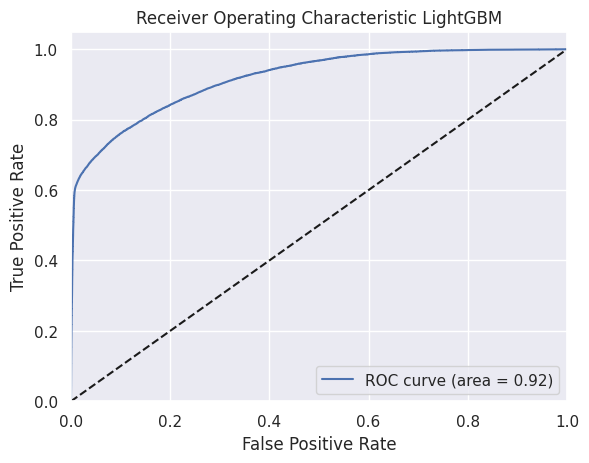

ROC-AUC на валидационной выборке: 0.92
Precision на валидационной выборке: 0.94
F1 на валидационной выборке: 0.74


In [96]:
params = {
   "seed": RANDOM_STATE,
   "metric": ['auc', 'precision'],
   "verbosity": 1,
   "valid_sets": [lgb.Dataset(X_valid, label=y_valid)],
   "gpu_device_id": -1,
   "plot": True
   }
lgbm = lgb.train(params, train_set=lgb.Dataset(X_train.drop(['purpose'], axis=1), label=y_train))

# Вычисление ROC-AUC
y_pred_lgb = lgbm.predict(X_valid.drop(['purpose'], axis=1))
roc_auc_lgb = roc_auc_score(y_valid, y_pred_lgb)

# Вычисление precision и F1
y_pred_class_lgb = (y_pred_lgb > 0.5).astype(int)
precision_lgb = precision_score(y_valid, y_pred_class_lgb)
f1_lgb = f1_score(y_valid, y_pred_class_lgb)

# Визуализация кривой ROC
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_valid, y_pred_lgb)
plt.plot(fpr_lgb, tpr_lgb, label='ROC curve (area = %0.2f)' % roc_auc_lgb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic LightGBM')
plt.legend(loc="lower right")
plt.show()

print(f"ROC-AUC на валидационной выборке: {round(roc_auc_lgb, 2)}")
print(f"Precision на валидационной выборке: {round(precision_lgb, 2)}")
print(f"F1 на валидационной выборке: {round(f1_lgb, 2)}")

## Выбор лучшей модели

In [97]:
dict_sum = {'Baseline': [roc_auc_baseline, precision_baseline, f1_baseline],
            'Catboost': [roc_auc_cb, precision_cb, f1_cb],
            'LightGBM': [roc_auc_lgb, precision_lgb, f1_lgb]}
summary_data = (pd.DataFrame.from_dict(dict_sum, orient='index',
                                       columns=["roc-auc", "precision", "f1_score"]).reset_index()
                                       .rename(columns={'index': 'model'})
                                       )
summary_data.sort_values('roc-auc', ascending=False).reset_index()

,index,model,roc-auc,precision,f1_score
0,1,Catboost,0.922594,0.931296,0.743651
1,2,LightGBM,0.919228,0.938478,0.742556
2,0,Baseline,0.899076,0.921752,0.707919


Проверка качества лучшей модели на тестовой выборке

In [99]:
# Вычисление ROC-AUC
y_proba_test = cbst.predict_proba(X_test.drop(['purpose_emb'], axis=1))[:, 1]
roc_auc_test = roc_auc_score(y_test, y_proba_test)

# Вычисление precision и F1
y_pred_test = cbst.predict(X_test.drop(['purpose_emb'], axis=1).values)
precision_test = precision_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"ROC-AUC на тестовой выборке: {round(roc_auc_test, 2)}")
print(f"Precision на тестовой выборке: {round(precision_test, 2)}")
print(f"F1 на тестовой выборке: {round(f1_test, 2)}")

ROC-AUC на тестовой выборке: 0.92
Precision на тестовой выборке: 0.93
F1 на тестовой выборке: 0.74


Выявление важности признаков

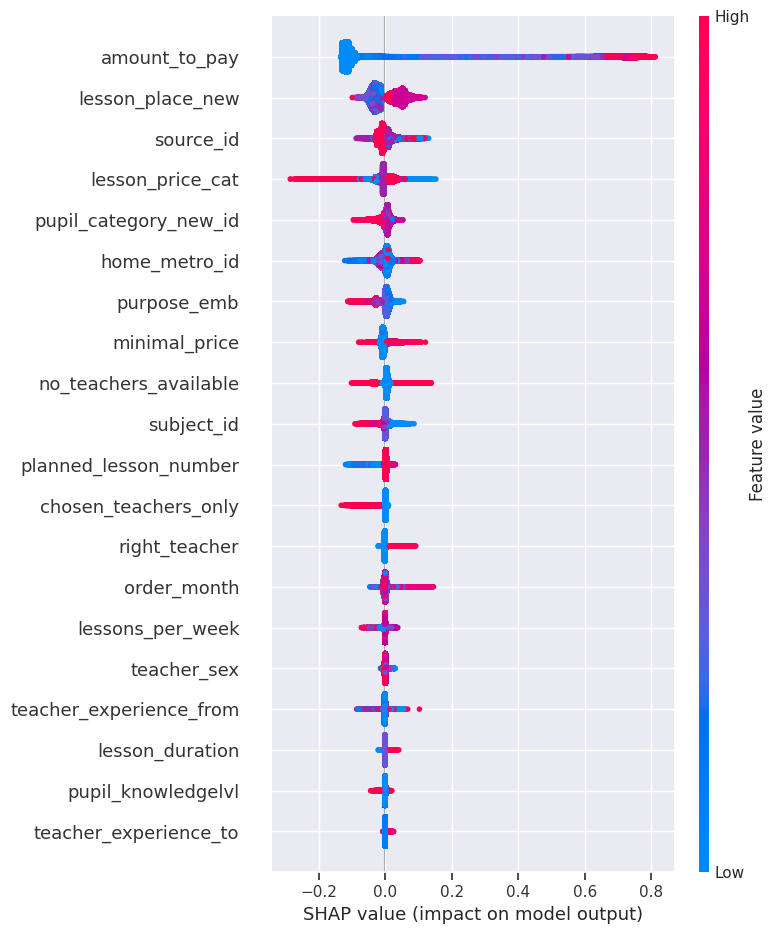

In [106]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train.drop(['purpose'], axis=1))
shap.summary_plot(shap_values, X_train.drop(['purpose'], axis=1))

#### Выводы и наблюдения
- лучшие значения метрик при обучении показала модель `Catboost`:
  - `ROC-AUC = 0.922594`
  - `Precision =	0.931296`
- метрики при проверке на отложенной выборке:
  - `ROC-AUC = 0.92`
  - `Precision =	0.93`
- наиболее важными признаками для модели выявлены:
  - `amount_to_pay`
  - `lesson_price_cat`

## Создание файла зависимостей

In [ ]:
!pip install pipreqs
!pipreqs /content --force
# !pip freeze > requirements.txt
# !pipreqsnb operator_performance_analytics.ipynb

  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=d7f4f1fb4750cef2c4b8e31b2bbd8bfa98a3dad33c8356a9c6eee84d4752c348
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
INFO: Successfully saved requirements file in /content/requirements.txt


## Заключение